In [2]:
import numpy as np
import pandas as pd
from apriori_python import apriori
import plotly.express as px
import matplotlib.pyplot as plt
import time
from efficient_apriori import apriori as ef_ap
from fpgrowth_py import fpgrowth
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:

attr_names = ["class", "age", "sex", "histologic-type", "degree-of-diffe", "bone", "bone-marrow", "lung", "pleura", "peritoneum", "liver", "brain", "skin", "neck", "supraclavicular", "axillar", "mediastinum", "abdominal"]

df = pd.read_csv('data/primary-tumor.data', names=attr_names)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   class            339 non-null    int64
 1   age              339 non-null    int64
 2   sex              339 non-null    int64
 3   histologic-type  339 non-null    int64
 4   degree-of-diffe  339 non-null    int64
 5   bone             339 non-null    int64
 6   bone-marrow      339 non-null    int64
 7   lung             339 non-null    int64
 8   pleura           339 non-null    int64
 9   peritoneum       339 non-null    int64
 10  liver            339 non-null    int64
 11  brain            339 non-null    int64
 12  skin             339 non-null    int64
 13  neck             339 non-null    int64
 14  supraclavicular  339 non-null    int64
 15  axillar          339 non-null    int64
 16  mediastinum      339 non-null    int64
 17  abdominal        339 non-null    int64
dtypes: int64(1

In [4]:
from sklearn.model_selection import train_test_split

df_source = df
# df_test = df[250:0]

X = df_source.drop(['degree-of-diffe'], axis=1)
y = df_source["degree-of-diffe"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

271
68


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

kernel = "sigmoid"

def GET_Metrics(model, X_train, X_test, y_train, y_test):  
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    svm_result = pd.DataFrame([kernel, train_accuracy, test_accuracy, train_recall, test_recall, train_precision, test_precision, train_f1, test_f1]).transpose()
    svm_result.columns = ['Method', "Train accuracy", "Test accuracy", "Train recall", "Test recall", "Train precision", "Test precision", "Train F1", "Test F1"]
    return svm_result


test_svm = RandomForestClassifier(n_estimators=100, max_depth=10)
test_svm.fit(X_train, y_train)
test_svm2 = RandomForestClassifier(n_estimators=100, max_depth=10)
test_svm2.fit(X_train, y_train)
test_svm3 = RandomForestClassifier(n_estimators=300, max_depth=5)
test_svm3.fit(X_train, y_train)
test_svm4 = RandomForestClassifier(n_estimators=100, max_depth=10, max_features="log2", min_samples_split=5)
test_svm4.fit(X_train, y_train)

res_dfs = [GET_Metrics(test_svm, X_train, X_test, y_train, y_test), 
           GET_Metrics(test_svm2, X_train, X_test, y_train, y_test), 
           GET_Metrics(test_svm3, X_train, X_test, y_train, y_test), 
           GET_Metrics(test_svm4, X_train, X_test, y_train, y_test)] 
results = pd.concat(res_dfs)
results

,Method,Train accuracy,Test accuracy,Train recall,Test recall,Train precision,Test precision,Train F1,Test F1
0,sigmoid,0.918819,0.529412,0.918819,0.529412,0.922404,0.4955,0.91814,0.504403
0,sigmoid,0.904059,0.544118,0.904059,0.544118,0.908788,0.516354,0.902835,0.513279
0,sigmoid,0.712177,0.529412,0.712177,0.529412,0.756349,0.478859,0.681196,0.48557
0,sigmoid,0.815498,0.544118,0.815498,0.544118,0.824903,0.507419,0.810204,0.514418


In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200],
              'max_depth': [None, 10],
              'min_samples_split': [2, 5],
              'max_features': ['sqrt', 'log2']}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

# Обучение GridSearchCV на обучающей выборке
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров и оценки качества
print('Best parameters:', grid_search.best_params_)
print('Train accuracy:', grid_search.best_score_)
print('Test accuracy:', grid_search.score(X_test, y_test))

best_svm = grid_search.best_estimator_

print(best_svm)
print()
GET_Metrics(best_svm, X_train, X_test, y_train, y_test)

Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100}
Train accuracy: 0.5645791245791246
Test accuracy: 0.5588235294117647
RandomForestClassifier(max_depth=10, max_features='log2', min_samples_split=5)


,Method,Train accuracy,Test accuracy,Train recall,Test recall,Train precision,Test precision,Train F1,Test F1
0,sigmoid,0.819188,0.558824,0.819188,0.558824,0.831421,0.519193,0.813201,0.524829


In [15]:
y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

339


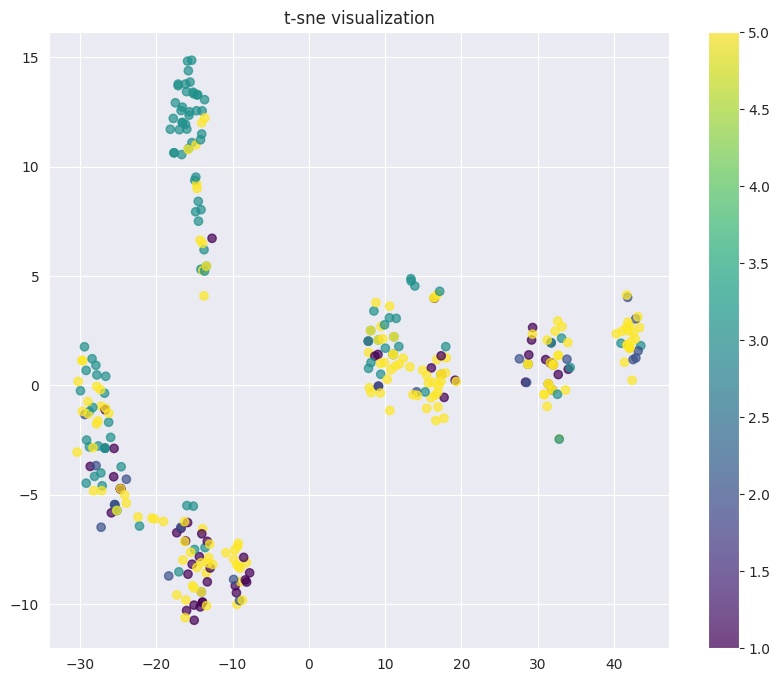

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

print(len(X_tsne))

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[:], cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('t-sne visualization')
plt.show()

339


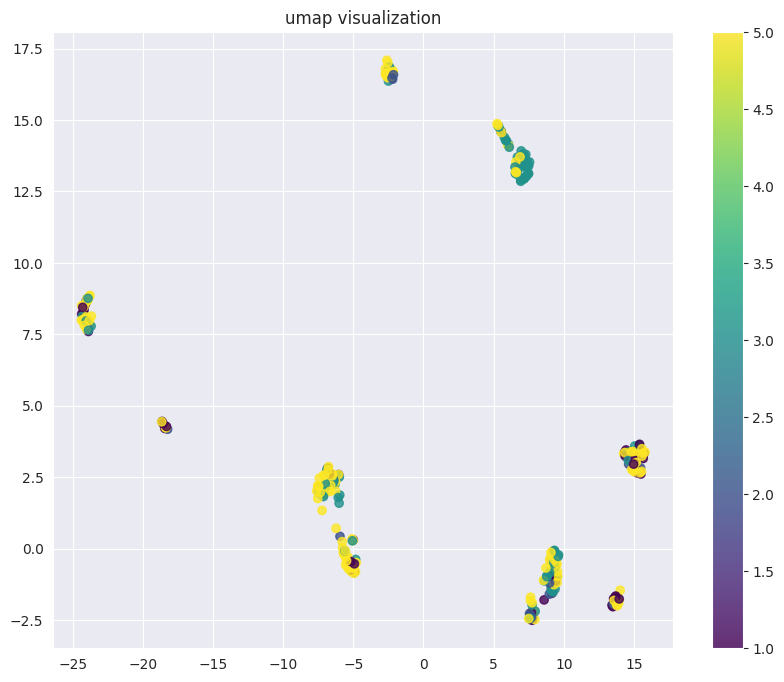

In [20]:
import umap


umap = umap.UMAP(n_components=2)
X_umap = umap.fit_transform(X)

print(len(X_umap))

plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y[:], cmap='viridis', alpha=0.8)
plt.colorbar()
plt.title('umap visualization')
plt.show()

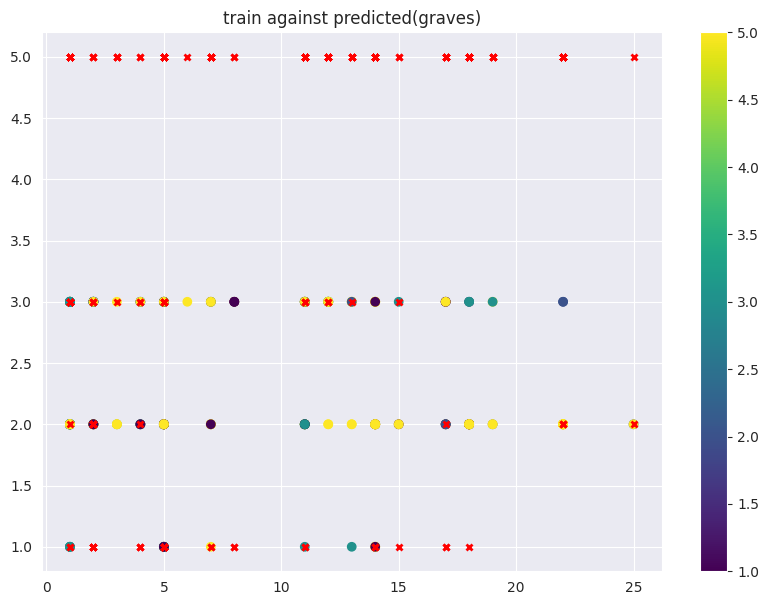

In [21]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train.iloc[:,0].values, X_train.iloc[:,1].values, c=y_train, cmap='viridis', alpha=1)
plt.title('train against predicted(graves)')
plt.plot(X_train.iloc[:,0].values, y_train_pred, 'x', color='red', markeredgewidth=2, markersize=5)
plt.colorbar()
plt.show()


In [1]:
plt.figure(figsize=(10, 7))
plt.scatter(X_test.iloc[:,0].values, X_test.iloc[:,1].values, c=y_test, cmap='viridis', alpha=1)
plt.title('test against predicted(graves)')
# plt.subplot(122)
plt.plot(X_test.iloc[:,0].values, y_test_pred, 'x', color='red', markeredgewidth=2, markersize=5)
plt.colorbar()
plt.show()

NameError: name 'plt' is not defined